# Overview of Course

The course is divided into 5 modules for ease of use and learning the significance of each concept at hand. 

The modules are as follows, 
1. Installation and Setup
2. Basics
    - Project
    - Python
    - Signal processing
3. Communicating with KITT. (Modules 1 and 2)
4. Localization using microphones. (Module 3)
5. Path planning and System integration. (Modules 4 and 5)

# Module 1 

## KITT Basics

KITT is based on a repurposed toy car model, the Traxass E-MAXX. 

### pySerial - Communicating with KITT

pySerial is a Python module that provides a simple and efficient way to communicate with serial ports. It allows Python programs to access and manipulate the serial ports on a computer, allowing them to communicate with other devices connected to those ports. With pySerial, you can easily send and receive data to/from these devices. pySerial is cross-platform, which works on Windows, macOS, and Linux operating systems.

- *serial.Serial(port, baud rate)* - This command initializes a serial connection. The port argument specifies the serial port to use (e.g., "COM1" on Windows or "/dev/rfcomm0" on Linux),
and the baud-rate argument specifies the data rate in bits per second.
- *serial.write(data)* - This command sends data over the serial connection. The data argument is a bytes object that contains the data to be sent.
- *serial.read(size)* - This command reads a specified number of bytes from the serial connection. It blocks until the specified number of bytes is received.
- *serial.flush()* - This command is used to flush the input and output buffers of the serial connection.
- *serial.close()* - This command is used to close the serial connection.

### Controlling KITT

After connecting to KITT, commands are required to control it. First off, for *driving* there are 2 types of instructions:

-  A direction command.
-  A motor speed command.
These are controlled using Pulse width modulation.

Few concepts used are OOK and PWM, 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal                  # For filter function
from scipy.fft import fft, ifft           # For fft and ifft
import math                               # For numerical approximation of pi

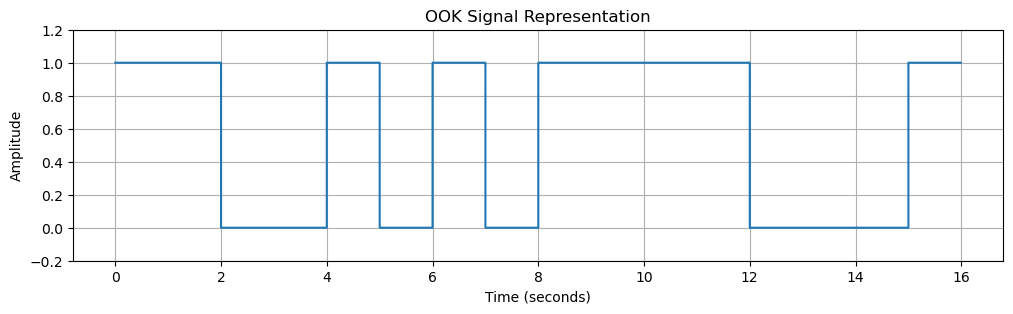

In [19]:
def generate_ook_signal(data, bit_duration=1, sampling_rate=100):
    """
    Generates an OOK signal from binary data.
    Parameters:
        data (str): Binary string to be transmitted.
        bit_duration (float): Duration of each bit in seconds.
        sampling_rate (int): Number of samples per second.
    Returns:
        t (numpy array): Time vector for the signal.
        ook_signal (numpy array): The OOK signal.
    """
    # Number of samples per bit
    samples_per_bit = int(bit_duration * sampling_rate)
    
    # Generate the signal
    ook_signal = np.repeat([int(bit) for bit in data], samples_per_bit)
    total_samples = len(ook_signal)
    t = np.linspace(0, total_samples / sampling_rate, total_samples, endpoint=False)
    
    return t, ook_signal

# Binary data to be transmitted
data = "1100101011110001"

# Generate OOK signal
t, ook_signal = generate_ook_signal(data)

# Plotting
plt.figure(figsize=(12, 3))
plt.step(t, ook_signal, where='post')
plt.ylim(-0.2, 1.2)
plt.title('OOK Signal Representation')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Module 2

KITT can only drive autonomously if it is able to sense its environment. Two types of sensors are provided: 
(i) Two distance sensors mounted on the front of KITT, and 
(ii) Five microphones located around the field which can record the audio transmitted by the beacon on top of KITT and send it to the PC.

The idea of this task is to understand how to read out distance sensors in front of KITT to avoid obstacles and reading information from the microphones placed in the field. 

At this point, the microphone data is interleaved: data[0] contains the first sample of microphone 0, data[1] contains the first sample of microphone 1, data[2] contains the first sample of microphone 2, and so on until data[5] contains the second sample of microphone 0. The table explains the concept more visually. This interleaved data stream should be deinterleaved into 5 streams, one for each microphone.

| data[0]      | data[1]      | data[2]      | data[3]      | data[4]      | data[5]      | data[6]      | data[7]      | ... |
|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|-----|
| mic 0        | mic 1        | mic 2        | mic 3        | mic 4        | mic 0        | mic 1        | mic 2        | ... |
| frame 0      | frame 0      | frame 0      | frame 0      | frame 0      | frame 1      | frame 1      | frame 1      | ... |

If one wants to plot audio data in real time, consider using a more low-level GUI library such as PyGame can be used. But it provides a lot more functionality and room for improvement if we build one according to our criteria. After the end of this overview, you will find a Demo verison of the GUI which is able to follow direction and steering instructions.


# Module 3: Locating KITT using Audio Communication

KITT must be located in its field and then directions must be determined to navigate to the final destination. In the previous modules your colleagues are developing scripts to communicate with KITT. They will add functionality to read the audio signals from the microphones located around the field, and you should use these to locate the car. It is recommended to read Modules 1 and 2 to have a better understanding of how everything should work together.

For the localization, we will use (real-time) recordings of the beacon signal at the various microphones, deconvolve these using a reference signal recording, and determine the relative time delays from the resulting channel estimates. Depending on the distance to each microphone, the signal transmitted by KITT’s beacon arrives a little bit earlier or later, and you can convert that into physical distances. For each pair of microphones, we can compute this time difference of arrival (TDOA), or the physical difference in propagation distance. If you have measurements from enough microphones, then you can calculate the location of KITT in the field.

7 recodings with known locations and a reference recording taken close to the microphone will be provided in this task. This can be used to develop and test your algorithms.

## Pre-recorded data

These recordings have locations randomly distributed across the field. An example recording with the location are, 

|   x   |   y   |
|-------|-------|
|  64   |   40  |
|  82   |  399  |
|  109  |   76  |
|  143  |  296  |
|  150  |  185  |
|  178  |  439  |
|  232  |  275  |

Signal processing concepts used in this module are Deconvolution, correlation, TDOA estimation and so on. Few are illustrated below, 


Text(0.5, 0, 'n')

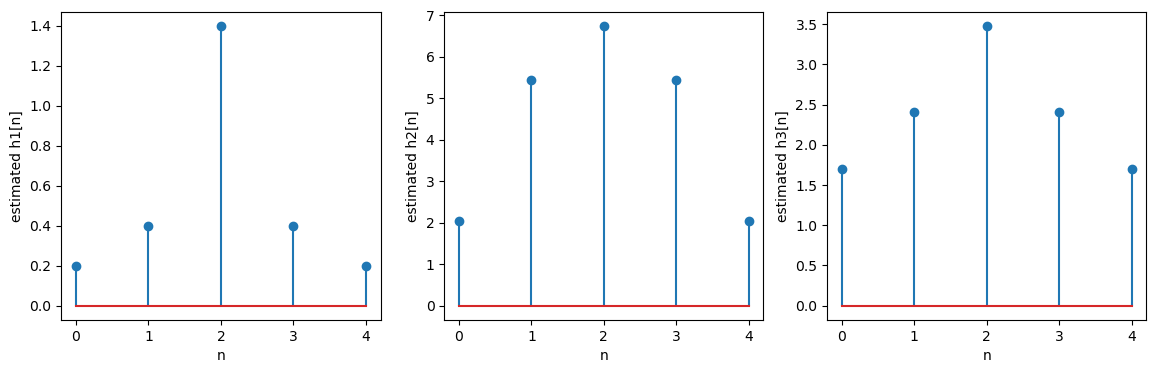

In [20]:
def ch2(x,y,Lhat):
    # length of x
    Nx = len(x)

    ## Efficient implementation using a convolution
    hhat = np.convolve(y, np.flip(x))
    hhat = hhat[Nx-1:]  # skip first Nx-1 entries
    hhat = hhat[0:Lhat] # truncate to length Lhat

    # scaling: hhat to h
    alpha = np.dot(x,x)   # scaling
    h = hhat/alpha
    return h

# Length
N = 100
h = np.array([1, 2, 3, 2, 1])

## Input
# Signals: define x1, x2, x3
x1 = np.array([1, -0.5])
x1 = np.append(x1, [0]*(N-2))

omega = 0.2*math.pi
x2 = np.cos(omega*np.arange(N))

x3 = np.sign(np.random.rand(N)-0.5)

## output: y1, y2, y3
y1 = np.convolve(x1,h)
y2 = np.convolve(x2,h)
y3 = np.convolve(x3,h)

## compute: hhat1, hhat2, hhat3
Loffset = 0      # this can be varied from 0 to something big (100) or even negative (-2)
hhat1 = ch2(x1,y1,len(h) + Loffset)
hhat2 = ch2(x2,y2,len(h) + Loffset)
hhat3 = ch2(x3,y3,len(h) + Loffset)

# Plot, make sure to add add label and title
# Visualization of the estimated channels
plt.figure(figsize=(14,4))
#
plt.subplot(131)
plt.stem(hhat1)
plt.ylabel('estimated h1[n]')
plt.xlabel('n')
#
plt.subplot(132)
plt.stem(hhat2)
plt.ylabel('estimated h2[n]')
plt.xlabel('n')
#
plt.subplot(133)
plt.stem(hhat3)
plt.ylabel('estimated h3[n]')
plt.xlabel('n')

Text(0.5, 0, 'n')

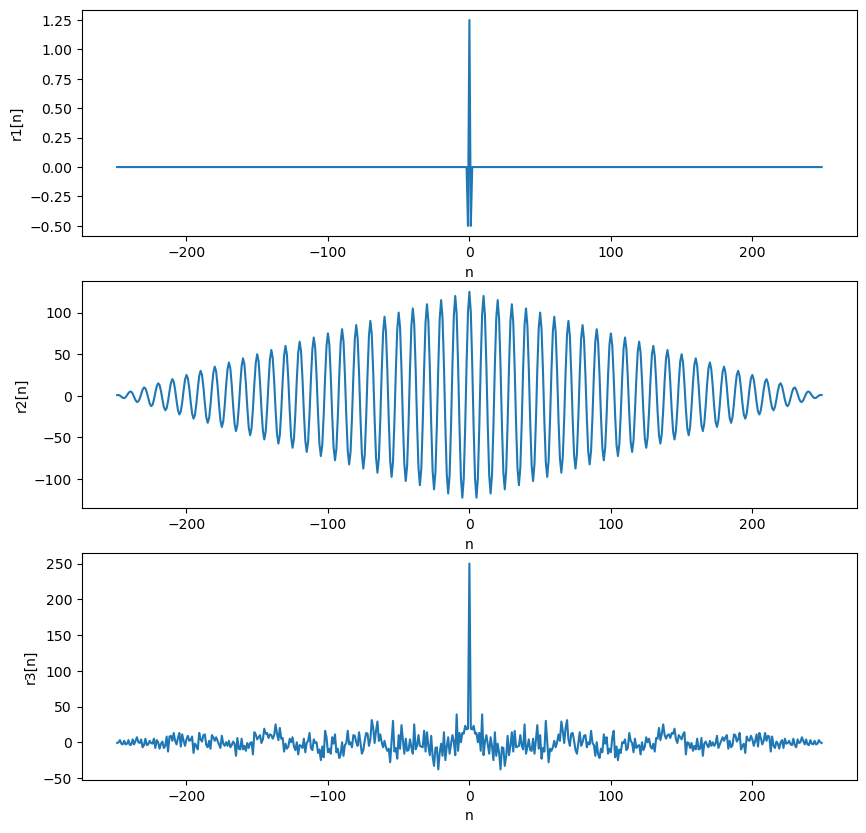

In [21]:
N = 250 # Length

# Signals : define x1, x2, x3
x1 = np.array([1, -0.5])
x1 = np.append(x1, [0]*(N-2))

omega = 0.2*math.pi
x2 = np.cos(omega*np.arange(N))

x3 = np.sign(np.random.rand(N)-0.5)

# find r1, r2, r3
r1 = np.convolve(x1,np.flipud(x1))
r2 = np.convolve(x2,np.flipud(x2))
r3 = np.convolve(x3,np.flipud(x3))

# Time axis
n = range(-N+1, N)

plt.figure(figsize=(10,10))
#
plt.subplot(311)
plt.plot(n,r1)
plt.ylabel('r1[n]')
plt.xlabel('n')
#
plt.subplot(312)
plt.plot(n,r2)
plt.ylabel('r2[n]')
plt.xlabel('n')
#
plt.subplot(313)
plt.plot(n,r3)
plt.ylabel('r3[n]')
plt.xlabel('n')

# Module 4

## Velocity Model

We start by driving on a straight line, and consider a simple model of longitudinal KITT dynamics,
described by Newton’s second law. The car’s motion is influenced by the following three forces:

• Accelerating force Fa due to the torque delivered by the engine.
• Braking force Fb due to the brakes. This force clearly opposes the motion and decelerates the car.
Unfortunately, KITT does not have a brake! You can stop by letting KITT roll to standstill, or for a
short period apply a negative force Fb. The difference with a real brake is that if you apply Fb for
too long, or were already stopped, the car will drive backwards.
• Force Fd due to the air drag and other types of friction. This opposing force also decelerates the
car and depends on the velocity v as, 

$
F_d = b|v| + cv^2
$
The absolute value is needed to ensure the friction opposes the driving direction.

## Velocity assignments

Our aim is to take our theoretical model, and tune it to the real KITT, by estimating the relevant parame-
ters (i.e., model identification). As it is a simple model, it is not going to be perfect. The dynamics of the
car are non-linear, e.g., it takes some extra force to make the car start driving. Also in practice battery
conditions do not remain constant, the car dynamics are then time-varying. 

A specific velocity model and steering model have been designed to mimic the behaviour of the real car. The simulator physics is described thoroughly and it is to be used as a guide for producing signals to the GUI. 

## Steering Model

If we steer a car by making the front wheels make an angle to the baseline, then the car will follow a
circle. The angle φ of the wheels will determine the radius R of the circle (if the angle is zero, then the
radius will become infinity: driving straight is a limit case). The dynamic model for driving on a line
from the previous section remains valid, except that it now describes the distance we drive on the circle.
Thus, the hard part at this point is to derive a relation between the angle φ and the radius R.

So essentially the assignent starts with assuming a constant velocity. Derive an equation for the radius R of the circle as function of steering angle φ.

## Combined Model 

As the final step, combine the steering model with the earlier velocity model to also update v over the
same period ∆t.
We recommend to create a class KITTmodel, with a very similar interface as the earlier class KITT,
i.e., it accepts the same driving and steering commands. The virtual model can update the state parame-
ters accordingly, each time the state is requested and each time the speed or steering setting is changed.
You will need an internal timer to track how much time has elapsed since the previous time the state was
updated (i.e., ∆t, which is not a constant).
This is more advanced OOP, and tricky to debug due to the real-time aspects. Develop this first for just
the velocity part and a one-dimensional distance z.
Alternatively, you can opt for a simpler approach where you develop a simple script that carries out a
series of commands, and records the resulting positions.

# Module 5: State tracking and Control 

This module covers advanced topics which lets KITT follow predefined trajectory and also maintain it's course. Intuitively, you will think of a solution where you know your current position/orientation, and you always
steer towards the target. Once you are oriented towards the target, your “angle error” is zero, and you
just have to drive straight. In all other cases, the angle error determines how much you need to steer. It
is easy to see that this approach might work, but also might become unstable once you are very close to
the target.

The simulator GUI can also be a great tool to illustrate this to some extent as it has a lot of new and complex concepts so the breakdown of a few parts would help in the understanding signficantly. Obstacle avoidance can also be achieved as a bonus goal as part of this module. 

All the above information provides a background for the structure of the manual. Now we move on to the Demo of the GUI following the dynamics of the car. In the future, we hope to extend this to all the functions of the Manual and help in illustrating them well. 

